In [1]:
!pip install transformers pandas torch
!pip install datasets
!pip install lime

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [18]:
import os
import csv
import pandas as pd
import torch
from transformers import PegasusTokenizer, PegasusForConditionalGeneration
from tqdm.notebook import tqdm
from google.colab import drive
from datasets import load_dataset
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, RobertaTokenizer, RobertaForSequenceClassification, DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from datasets import Dataset
from lime.lime_text import LimeTextExplainer
import string
from nltk.corpus import stopwords
import nltk
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Loading dataset from huggingFace
# train_set = load_dataset("Ateeqq/AI-and-Human-Generated-Text", split="train")
# test_set = load_dataset("Ateeqq/AI-and-Human-Generated-Text", split="test")

# File path in Google Drive to get the dataset
train_file = "/content/drive/My Drive/Colab Notebooks/Dataset/train_data.csv"
test_file = "/content/drive/My Drive/Colab Notebooks/Dataset/test_data.csv"

# Converted the datasets to Pandas DataFrames
df_train = pd.read_csv(train_file)
df_test = pd.read_csv(test_file)

print(len(df_train))
print(len(df_test))

5965
5532


In [6]:
# Initializing stopwords to remove from dataset
stop = set(stopwords.words('english'))

def preprocess_text(df):
    df.drop_duplicates(subset=['abstract'], inplace=True)
    df.dropna(subset=['abstract'], inplace=True)
    df['abstract'] = df['abstract'].str.lower()
    df['abstract'] = df['abstract'].str.replace(f"[{string.punctuation}]", "", regex=True)
    df['abstract'] = df['abstract'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop]))
    df['abstract'] = df['abstract'].str.replace(r"[^a-zA-Z0-9\s]", "", regex=True)
    df['abstract'] = df['abstract'].str.strip().replace(r"\s+", " ", regex=True)
    return df

# Preprocessing the train and test set
df_train = preprocess_text(df_train)
df_test = preprocess_text(df_test)

In [ ]:
# Initializing the Pegasus paraphrasing model and tokenizer for paraphrasing
device = 'cpu'
tokenizer = PegasusTokenizer.from_pretrained("tuner007/pegasus_paraphrase")
model = PegasusForConditionalGeneration.from_pretrained("tuner007/pegasus_paraphrase").to(device)


In [ ]:
# Function to paraphrase the data
def paraphrase_text(texts, max_length=300, num_beams=10):
    cleaned_texts = []
    for text in texts:
        tokens = tokenizer(text, truncation=True, padding=True, return_tensors="pt").input_ids.to(device)

        if tokens.max() >= tokenizer.vocab_size:
            print(f"Skipping the text due to out-of-range token: {text}")
        else:
            cleaned_texts.append(text)
    # Returning empty paraphrased text if all texts are skipped
    if not cleaned_texts:
        return [""] * len(texts)
    tokens = tokenizer(cleaned_texts, truncation=True, padding=True, return_tensors="pt").input_ids.to(device)
    outputs = model.generate(tokens, max_length=max_length, num_beams=num_beams, temperature=1.5)
    paraphrased_texts = [tokenizer.decode(output, skip_special_tokens=True) for output in outputs]
    # Matching the output with the originallength of data
    output_texts = []
    for text in texts:
        if text in cleaned_texts:
            output_texts.append(paraphrased_texts.pop(0))
        else:
            output_texts.append("")

    return output_texts

In [ ]:
def process_and_save(df, output_file):
    processed_texts = set()

    # Checking if the output file exists
    if os.path.exists(output_file):
        with open(output_file, newline='', encoding='utf-8') as csvfile_out:
            reader = csv.DictReader(csvfile_out)
            for row in reader:
                processed_texts.add(row['abstract'])

    total_rows = len(df)

    # Opening the output file
    with open(output_file, 'a', newline='', encoding='utf-8') as csvfile_out:
        fieldnames = ['title', 'abstract', 'label', 'paraphrased_text']
        writer = csv.DictWriter(csvfile_out, fieldnames=fieldnames)

        # Writing the header to the output file only if the file is newly created
        if csvfile_out.tell() == 0:
            writer.writeheader()

        progress_bar = tqdm(total=total_rows, desc="Paraphrasing rows")

        for _, row in df.iterrows():
            if row['abstract'] in processed_texts:
                progress_bar.update(1)
                continue

            try:
                paraphrased_text = paraphrase_text([row['abstract']])[0]

                writer.writerow({
                    'title': row['title'],
                    'abstract': row['abstract'],
                    'label': row['label'],
                    'paraphrased_text': paraphrased_text
                })

                processed_texts.add(row['abstract'])

            except Exception as e:
                print(f"Error processing row {row['abstract']}: {e}")
                continue

            progress_bar.update(1)

        # Closing the progress bar
        progress_bar.close()

    print(f"Paraphrasing complete and saved to {output_file}")

process_and_save(df_test, test_file)

In [41]:
# Extracting features and labels from the train and test set
X_train = df_train['abstract'].tolist()
y_train = df_train['label'].tolist()

X_test = df_test['paraphrased_text'].tolist()
y_test = df_test['label'].tolist()
X_test_original = df_test['abstract'].tolist()

# Extracting the paraphrased text and labels from df_train
paraphrased_texts = df_train['paraphrased_text'].tolist()
paraphrased_labels = df_train['label'].tolist()

# Spliting the paraphrased texts into training and validation sets
X_train_paraphrased, X_val_paraphrased, y_train_paraphrased, y_val_paraphrased = train_test_split(
    paraphrased_texts, paraphrased_labels, train_size=1500, random_state=42
)

print(f"Training set size (paraphrased): {len(X_train_paraphrased)}")
print(f"Validation set size (paraphrased): {len(X_val_paraphrased)}")

Training set size (paraphrased): 1500
Validation set size (paraphrased): 4465


In [42]:
# Combine original and paraphrased data for training
X_train_combined = X_train + X_train_paraphrased
y_train_combined = y_train + y_train_paraphrased

train_dataset_combined = Dataset.from_dict({'text': X_train_combined, 'label': y_train_combined})
val_dataset_combined = Dataset.from_dict({'text': X_val_paraphrased, 'label': y_val_paraphrased})
test_dataset_combined = Dataset.from_dict({'text': X_test, 'label': y_test})
test_dataset_combined_original = Dataset.from_dict({'text': X_test_original, 'label': y_test})

In [9]:
len(train_dataset_combined)

7465

In [10]:
len(val_dataset_combined)

4465

In [11]:
len(test_dataset_combined)

5532

In [12]:
len(test_dataset_combined_original)

5532

In [43]:
def tokenize_function(examples, tokenizer):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=512)

model_names = [
    'bert-base-uncased',
    'roberta-base',
    'distilbert-base-uncased'
]

def evaluate_model(model_name, train_dataset, val_dataset, test_dataset, training_args):
    # Loading the appropriate tokenizer and model
    if 'bert-base-uncased' in model_name:
        tokenizer = BertTokenizer.from_pretrained(model_name)
        model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)
    elif 'roberta-base' in model_name:
        tokenizer = RobertaTokenizer.from_pretrained(model_name)
        model = RobertaForSequenceClassification.from_pretrained(model_name, num_labels=2)
    elif 'distilbert-base-uncased' in model_name:
        tokenizer = DistilBertTokenizer.from_pretrained(model_name)
        model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2)

    # Tokenizing the datasets
    train_dataset = train_dataset.map(lambda x: tokenize_function(x, tokenizer), batched=True)
    val_dataset = val_dataset.map(lambda x: tokenize_function(x, tokenizer), batched=True)
    test_dataset = test_dataset.map(lambda x: tokenize_function(x, tokenizer), batched=True)

    train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
    val_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
    test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

    # Adding EarlyStoppingCallback
    early_stopping = EarlyStoppingCallback(early_stopping_patience=3, early_stopping_threshold=0.0)

    # Initializing the Trainer with model-specific training arguments
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=lambda p: {
            "accuracy": accuracy_score(p.label_ids, p.predictions.argmax(-1)),
            "precision": precision_score(p.label_ids, p.predictions.argmax(-1)),
            "recall": recall_score(p.label_ids, p.predictions.argmax(-1)),
            "f1": f1_score(p.label_ids, p.predictions.argmax(-1)),
        },
        callbacks=[early_stopping]
    )

    # Training the model
    trainer.train()

    # Evaluating the model on the test set
    eval_results = trainer.evaluate(test_dataset)

    # Evaluating the model on the test set of original AI data
    eval_results = trainer.evaluate(test_dataset)

    # Predictions on the test set
    predictions = trainer.predict(test_dataset)
    y_true = predictions.label_ids
    y_pred_confusion = predictions.predictions.argmax(-1)
    y_pred_roc = torch.nn.functional.softmax(torch.tensor(predictions.predictions), dim=1).numpy()[:, 1]

    # Generating the confusion matrix
    cm = confusion_matrix(y_true, y_pred_confusion)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Human', 'AI'])
    disp.plot(cmap=plt.cm.YlGnBu)
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()

    # Generating ROC curve
    fpr, tpr, _ = roc_curve(y_true, y_pred_roc)
    roc_auc = auc(fpr, tpr)

    return model, tokenizer, eval_results, fpr, tpr, roc_auc

# Defining training arguments
training_args_dict = {
    'bert-base-uncased': TrainingArguments(
        output_dir='./results/bert',
        num_train_epochs=4,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir='./logs/bert',
        logging_steps=10,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        save_total_limit=2,
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
        logging_strategy="steps",
        eval_steps=10,
    ),
    'roberta-base': TrainingArguments(
        output_dir='./results/roberta',
        num_train_epochs=3,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        warmup_steps=400,
        weight_decay=0.02,
        logging_dir='./logs/roberta',
        logging_steps=10,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        save_total_limit=2,
        load_best_model_at_end=True,
        metric_for_best_model="eval_accuracy",
        greater_is_better=True,
        logging_strategy="steps",
        eval_steps=10,
    ),
    'distilbert-base-uncased': TrainingArguments(
        output_dir='./results/distilbert',
        num_train_epochs=5,
        per_device_train_batch_size=12,
        per_device_eval_batch_size=12,
        warmup_steps=300,
        weight_decay=0.01,
        logging_dir='./logs/distilbert',
        logging_steps=10,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        save_total_limit=2,
        load_best_model_at_end=True,
        metric_for_best_model="eval_f1",
        greater_is_better=True,
        logging_strategy="steps",
        eval_steps=10,
    )
}

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [44]:
device = "cpu"

# LIME Integration
def predict_proba(texts, model, tokenizer):
    # Tokenize the input texts
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=512)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    # Get the model's logits and convert to probabilities
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=1).cpu().numpy()

    return probs

def explain_instance_with_lime(text, model, tokenizer):
    explainer = LimeTextExplainer(class_names=['Human', 'AI'])
    explanation = explainer.explain_instance(
        text_instance=text,
        classifier_fn=lambda x: predict_proba(x, model, tokenizer),
        num_features=10,
        labels=[0, 1]
    )
    return explanation


In [19]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

Evaluating bert-base-uncased...
Evaluating bert-base-uncased on original dataset...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/7465 [00:00<?, ? examples/s]

Map:   0%|          | 0/4465 [00:00<?, ? examples/s]

Map:   0%|          | 0/5532 [00:00<?, ? examples/s]

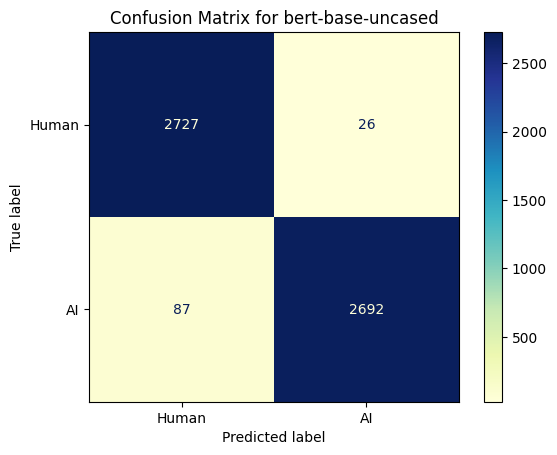

Evaluating bert-base-uncased on paraphrased dataset...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/7465 [00:00<?, ? examples/s]

Map:   0%|          | 0/4465 [00:00<?, ? examples/s]

KeyboardInterrupt: 

In [45]:
# Function for evaluating and storing results for both original and paraphrased datasets
def evaluate_model_on_both_datasets(model_name, train_dataset_combined, val_dataset_combined, test_dataset_combined, test_dataset_combined_original, training_args):

    print(f"Evaluating {model_name} on original dataset...")
    model, tokenizer, eval_results_original, fpr_original, tpr_original, roc_auc_original = evaluate_model(
        model_name, train_dataset_combined, val_dataset_combined, test_dataset_combined_original, training_args)

    print(f"Evaluating {model_name} on paraphrased dataset...")
    model, tokenizer, eval_results_paraphrased, fpr_paraphrased, tpr_paraphrased, roc_auc_paraphrased = evaluate_model(
        model_name, train_dataset_combined, val_dataset_combined, test_dataset_combined, training_args)

    return model, tokenizer, {
        'original': (eval_results_original, fpr_original, tpr_original, roc_auc_original),
        'paraphrased': (eval_results_paraphrased, fpr_paraphrased, tpr_paraphrased, roc_auc_paraphrased)
    }

results = {}

roc_data = {}

for model_name in model_names:
    print(f"Evaluating {model_name}...")
    training_args = training_args_dict[model_name]
    model, tokenizer, model_results = evaluate_model_on_both_datasets(model_name, train_dataset_combined, val_dataset_combined, test_dataset_combined, test_dataset_combined_original, training_args)
    results[model_name] = model_results
    roc_data[model_name] = {
        'original': model_results['original'][1:],
        'paraphrased': model_results['paraphrased'][1:]
    }

    # Explain a prediction using LIME
    text_to_explain = X_test[0]
    explanation = explain_instance_with_lime(text_to_explain, model, tokenizer)
    explanation.show_in_notebook(text=True)
    explanation.save_to_file(f"{model_name}_lime_explanation.html")



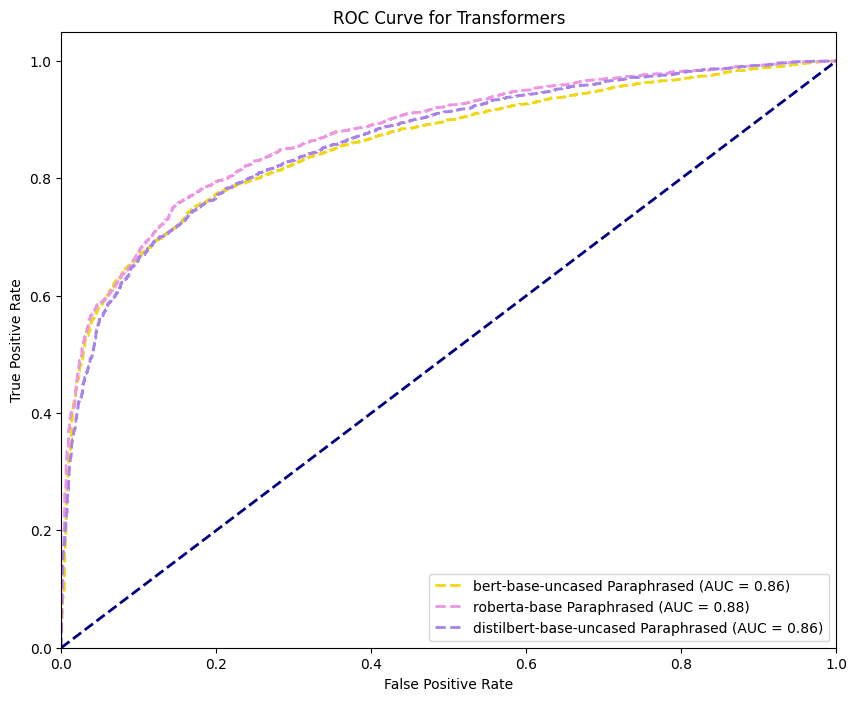

In [23]:
# Generating ROC curve
custom_colors = {
    'bert-base-uncased': '#F0D815',
    'roberta-base': '#ED96E1',
    'distilbert-base-uncased': '#A783EA',
}

# Custom legend names
custom_labels = {
    'bert-base-uncased': 'BERT',
    'roberta-base': 'RoBERTa',
    'distilbert-base-uncased': 'DistilBERT',
}

plt.figure(figsize=(10, 8))

for model_name in model_names:
    fpr_paraphrased, tpr_paraphrased, roc_auc_paraphrased = roc_data[model_name]['paraphrased']
    color = custom_colors.get(model_name, 'black')
    label = custom_labels.get(model_name, model_name)
    plt.plot(fpr_paraphrased, tpr_paraphrased, lw=2, color=color, linestyle='--', label=f'{model_name} Paraphrased (AUC = {roc_auc_paraphrased:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Transformers')
plt.legend(loc="lower right")
plt.show()

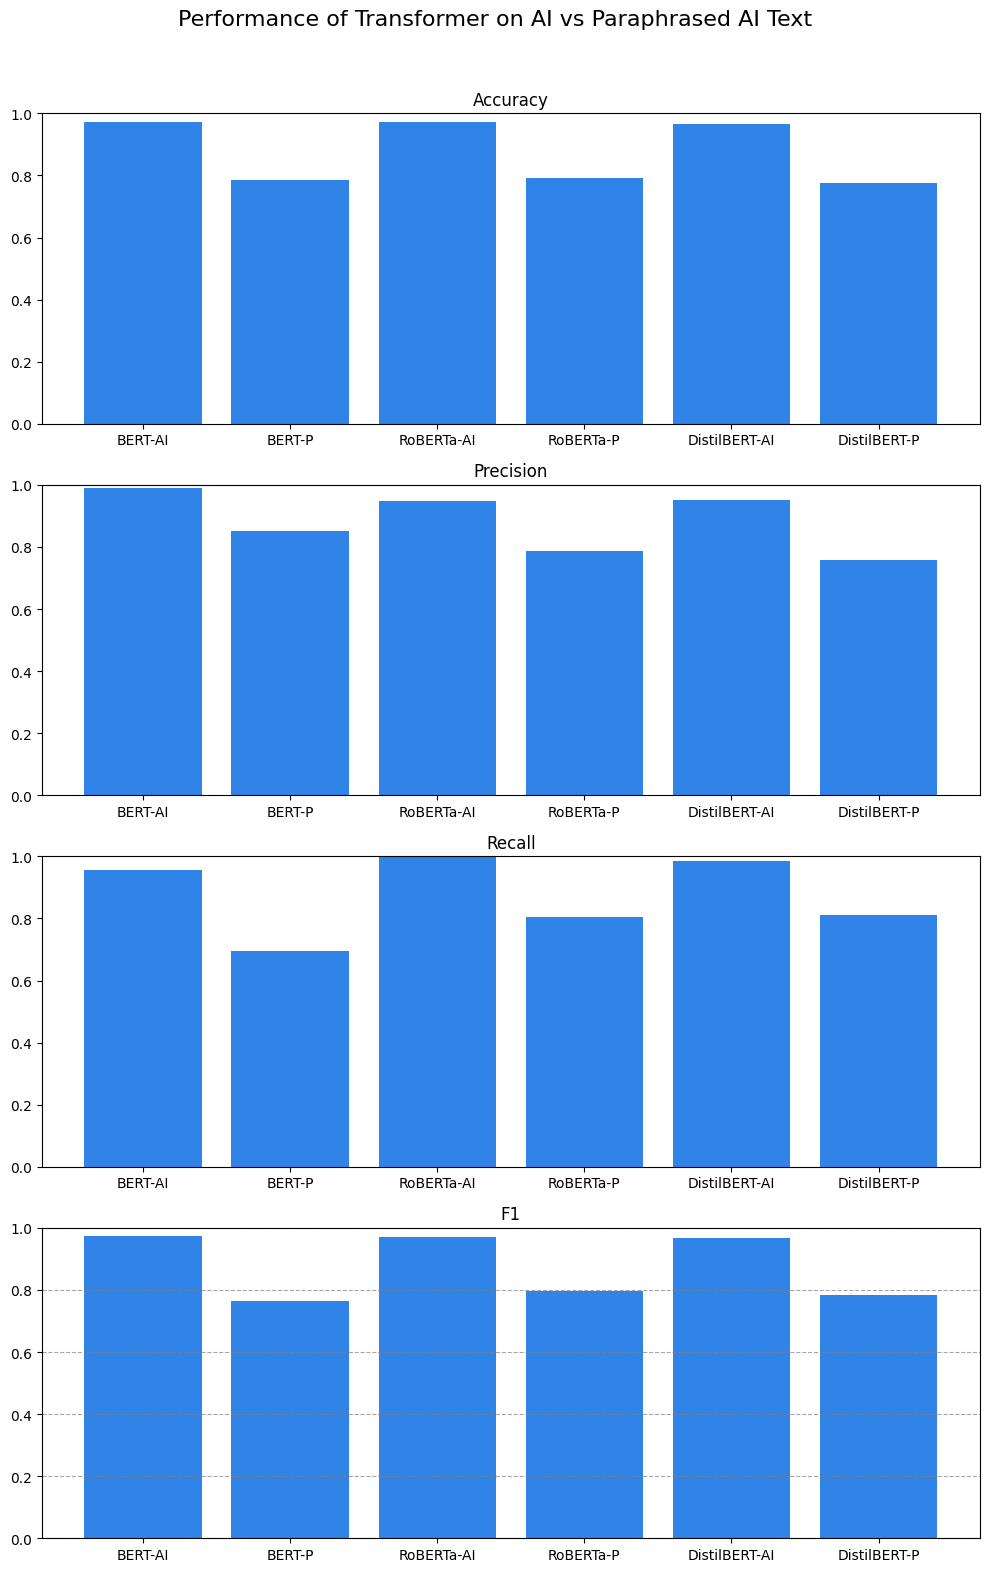

In [24]:
#Creating a bar chart comparing model performance for Transformer models
metrics = ['accuracy', 'precision', 'recall', 'f1']
comparison_data = {model_name: {metric: [] for metric in metrics} for model_name in model_names}

# Custom x-axis labels
custom_labels = {
    'bert-base-uncased': ['BERT-AI', 'BERT-P'],
    'roberta-base': ['RoBERTa-AI', 'RoBERTa-P'],
    'distilbert-base-uncased': ['DistilBERT-AI', 'DistilBERT-P']
}

# Custom colors for each model
bar_color = '#3083E7'

# Populate the comparison data dictionary
for model_name in model_names:
    for metric in metrics:
        comparison_data[model_name][metric].append(results[model_name]['original'][0][f'eval_{metric}'])
        comparison_data[model_name][metric].append(results[model_name]['paraphrased'][0][f'eval_{metric}'])

# Create subplots for the metrics with 4 rows and 1 column
fig, axes = plt.subplots(len(metrics), 1, figsize=(10, 16))
fig.suptitle('Performance of Transformer on AI vs Paraphrased AI Text', fontsize=16)

# Plot the data
for i, metric in enumerate(metrics):
    ax = axes[i]
    for model_name in model_names:
        original_label, paraphrased_label = custom_labels[model_name]
        ax.bar([original_label, paraphrased_label], comparison_data[model_name][metric],
               color=bar_color, label=model_name)
    ax.set_title(metric.capitalize())
    ax.set_ylim(0, 1)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.grid(axis='y', linestyle='--', color='gray', alpha=0.7)
plt.show()


In [26]:
for model_name, model_results in results.items():
    print(f"\nModel: {model_name}")

    # Access metrics for the original dataset
    original_metrics = model_results['original'][0]
    if 'eval_accuracy' in original_metrics:
        print(f"Original - Accuracy: {original_metrics['eval_accuracy']:.4f}")
    if 'eval_precision' in original_metrics:
        print(f"Original - Precision: {original_metrics['eval_precision']:.4f}")
    if 'eval_recall' in original_metrics:
        print(f"Original - Recall: {original_metrics['eval_recall']:.4f}")
    if 'eval_f1' in original_metrics:
        print(f"Original - F1 Score: {original_metrics['eval_f1']:.4f}")

    # Access metrics for the paraphrased dataset
    paraphrased_metrics = model_results['paraphrased'][0]
    if 'eval_accuracy' in paraphrased_metrics:
        print(f"Paraphrased - Accuracy: {paraphrased_metrics['eval_accuracy']:.4f}")
    if 'eval_precision' in paraphrased_metrics:
        print(f"Paraphrased - Precision: {paraphrased_metrics['eval_precision']:.4f}")
    if 'eval_recall' in paraphrased_metrics:
        print(f"Paraphrased - Recall: {paraphrased_metrics['eval_recall']:.4f}")
    if 'eval_f1' in paraphrased_metrics:
        print(f"Paraphrased - F1 Score: {paraphrased_metrics['eval_f1']:.4f}")



Model: bert-base-uncased
Original - Accuracy: 0.9732
Original - Precision: 0.9903
Original - Recall: 0.9561
Original - F1 Score: 0.9729
Paraphrased - Accuracy: 0.7852
Paraphrased - Precision: 0.8500
Paraphrased - Recall: 0.6952
Paraphrased - F1 Score: 0.7648

Model: roberta-base
Original - Accuracy: 0.9705
Original - Precision: 0.9473
Original - Recall: 0.9968
Original - F1 Score: 0.9714
Paraphrased - Accuracy: 0.7921
Paraphrased - Precision: 0.7869
Paraphrased - Recall: 0.8039
Paraphrased - F1 Score: 0.7953

Model: distilbert-base-uncased
Original - Accuracy: 0.9664
Original - Precision: 0.9513
Original - Recall: 0.9834
Original - F1 Score: 0.9671
Paraphrased - Accuracy: 0.7757
Paraphrased - Precision: 0.7589
Paraphrased - Recall: 0.8111
Paraphrased - F1 Score: 0.7841


#ML MODEL Analysis

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.pipeline import make_pipeline
from sklearn.calibration import CalibratedClassifierCV


In [28]:
# Extracting Text and Labels
X_train_texts = train_dataset_combined['text']
y_train = train_dataset_combined['label']

X_val_texts = val_dataset_combined['text']
y_val = val_dataset_combined['label']

X_test_texts = test_dataset_combined['text']
y_test = test_dataset_combined['label']

# Initializing the TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=5000)

# Vectorizing the Text Data
X_train_vec = vectorizer.fit_transform(X_train_texts)
X_val_vec = vectorizer.transform(X_val_texts)
X_test_vec = vectorizer.transform(X_test_texts)

models = {
    'SVM': SVC(kernel='linear', C=1.0, probability=True),
    'Logistic Regression': LogisticRegression(max_iter=500, C=0.5, solver='liblinear'),
    'Passive Aggressive': CalibratedClassifierCV(PassiveAggressiveClassifier(max_iter=1000, C=0.1, tol=1e-4), method='sigmoid', cv=5)
}

# LIME Integration for ML Models
def explain_instance_with_lime_ml(text, model, vectorizer):
    explainer = LimeTextExplainer(class_names=['Human', 'AI'])

    # Define a pipeline with vectorizer and model
    pipeline = make_pipeline(vectorizer, model)

    # Generate explanation
    explanation = explainer.explain_instance(
        text_instance=text,
        classifier_fn=pipeline.predict_proba,
        num_features=10,
        labels=[0, 1]
    )

    return explanation


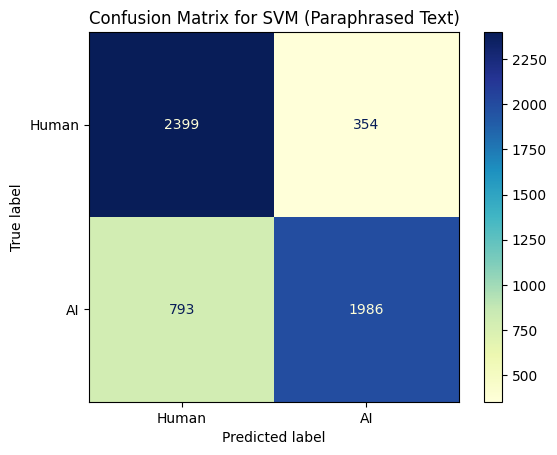

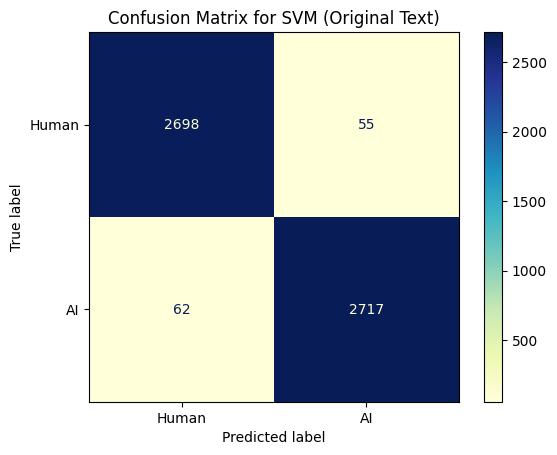

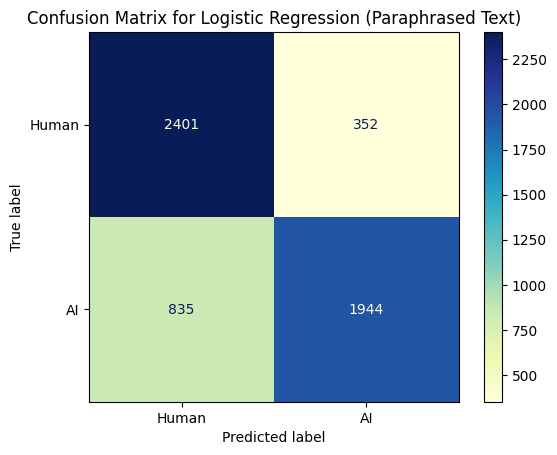

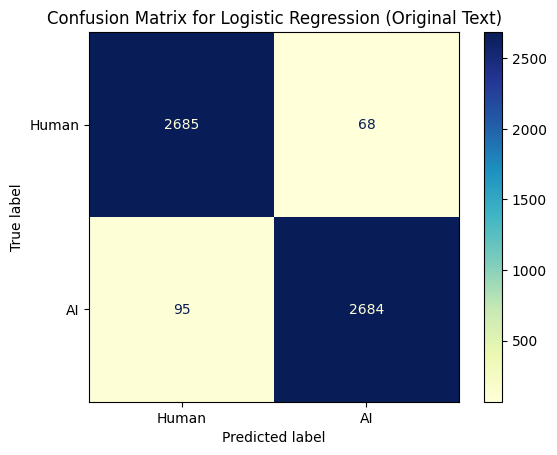

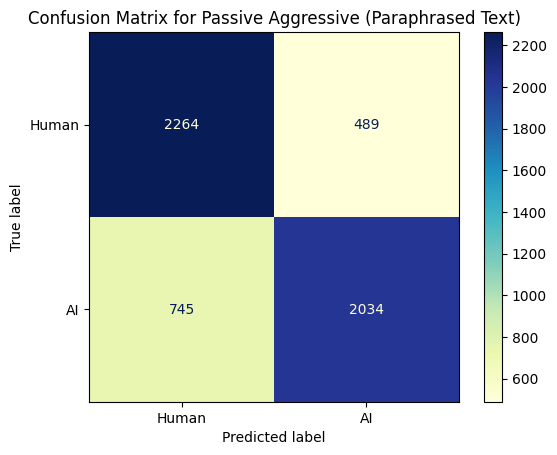

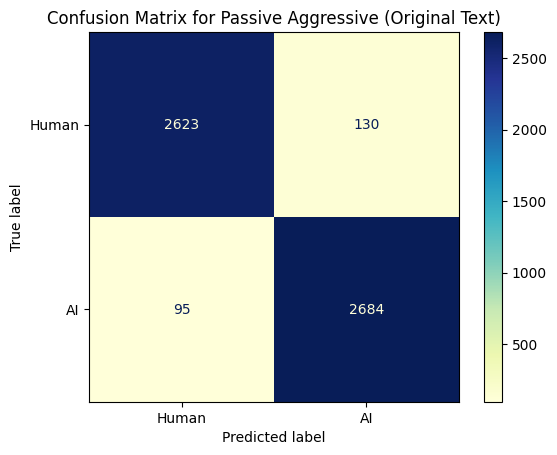

In [29]:
def evaluate_on_texts(model_name, model, vectorizer, X_test_vec, y_test, text_type="Paraphrased"):

    if hasattr(model, "predict_proba"):
        y_pred_probs = model.predict_proba(X_test_vec)[:, 1]
    else:
        y_pred_probs = model.decision_function(X_test_vec)
        y_pred_probs = (y_pred_probs - y_pred_probs.min()) / (y_pred_probs.max() - y_pred_probs.min())

    # Predict on the test set
    y_pred = model.predict(X_test_vec)

    # Generate the confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Human', 'AI'])
    disp.plot(cmap=plt.cm.YlGnBu)
    plt.title(f"Confusion Matrix for {model_name} ({text_type} Text)")
    plt.show()

    # Generate and collect ROC curve data only for paraphrased text
    fpr, tpr, roc_auc = None, None, None
    if text_type == "Paraphrased":
        fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
        roc_auc = auc(fpr, tpr)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Return the performance metrics and ROC data
    return {
        'Model': model_name,
        'Text Type': text_type,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc
    }, fpr, tpr, roc_auc


results = []
roc_data = {}

for model_name, model in models.items():
    model.fit(X_train_vec, y_train)

    # Evaluating on paraphrased AI text
    paraphrased_metrics, fpr_paraphrased, tpr_paraphrased, roc_auc_paraphrased = evaluate_on_texts(
        model_name, model, vectorizer, X_test_vec, y_test, text_type="Paraphrased"
    )
    results.append(paraphrased_metrics)
    roc_data[f'{model_name}_Paraphrased'] = (fpr_paraphrased, tpr_paraphrased, roc_auc_paraphrased)


    # Evaluating on original AI text
    X_test_vec_original = vectorizer.transform(test_dataset_combined_original['text'])
    y_test_original = test_dataset_combined_original['label']
    original_metrics, fpr_original, tpr_original, roc_auc_original = evaluate_on_texts(
        model_name, model, vectorizer, X_test_vec_original, y_test, text_type="Original"
    )
    results.append(original_metrics)
    roc_data[f'{model_name}'] = (fpr_paraphrased, tpr_paraphrased, roc_auc_paraphrased)

    # Explain a prediction using LIME
    text_to_explain = X_test_texts[0]
    explanation = explain_instance_with_lime_ml(text_to_explain, model, vectorizer)
    explanation.show_in_notebook(text=True)
    explanation.save_to_file(f"{model_name}_lime_explanation_ml.html")

In [30]:
for result in results:
    print(f"\nModel: {result['Model']}")
    print(f"Text Type: {result['Text Type']}")
    print(f"Accuracy: {result['Accuracy']:.4f}")
    print(f"Precision: {result['Precision']:.4f}")
    print(f"Recall: {result['Recall']:.4f}")
    print(f"F1 Score: {result['F1 Score']:.4f}")


Model: SVM
Text Type: Paraphrased
Accuracy: 0.7927
Precision: 0.8487
Recall: 0.7146
F1 Score: 0.7759

Model: SVM
Text Type: Original
Accuracy: 0.9789
Precision: 0.9802
Recall: 0.9777
F1 Score: 0.9789

Model: Logistic Regression
Text Type: Paraphrased
Accuracy: 0.7854
Precision: 0.8467
Recall: 0.6995
F1 Score: 0.7661

Model: Logistic Regression
Text Type: Original
Accuracy: 0.9705
Precision: 0.9753
Recall: 0.9658
F1 Score: 0.9705

Model: Passive Aggressive
Text Type: Paraphrased
Accuracy: 0.7769
Precision: 0.8062
Recall: 0.7319
F1 Score: 0.7673

Model: Passive Aggressive
Text Type: Original
Accuracy: 0.9593
Precision: 0.9538
Recall: 0.9658
F1 Score: 0.9598


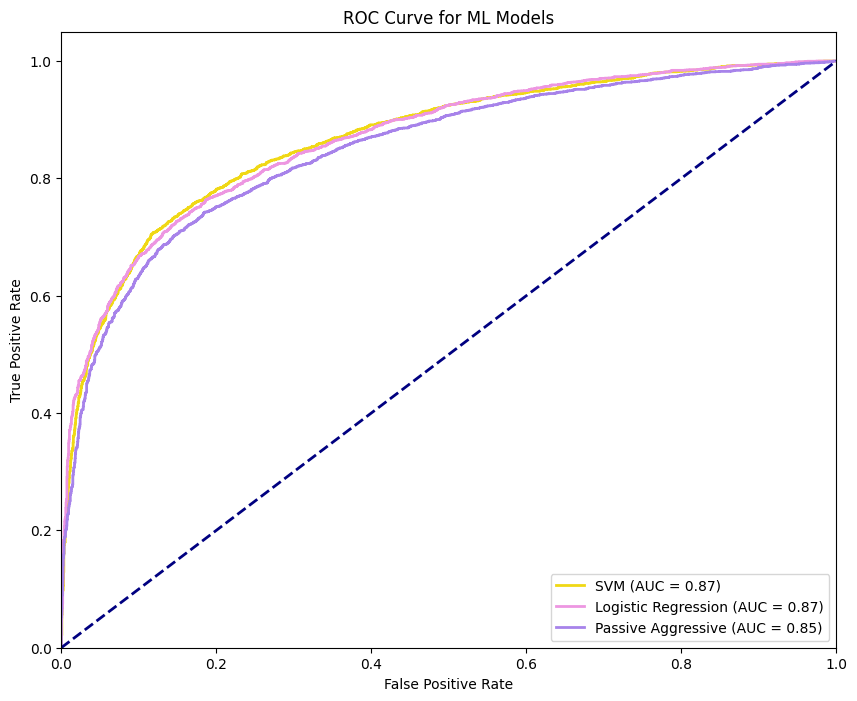

In [32]:
custom_colors = {
    'SVM': '#F0D815',
    'Logistic Regression': '#ED96E1',
    'Passive Aggressive': '#A783EA',
}

plt.figure(figsize=(10, 8))
added_models = set()

for key, (fpr, tpr, roc_auc) in roc_data.items():
    model_name = key.split('_')[0]
    color = custom_colors.get(model_name, 'black')

    if model_name not in added_models:
        plt.plot(fpr, tpr, lw=2, color=color, label=f'{model_name} (AUC = {roc_auc:.2f})')
        added_models.add(model_name)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for ML Models')
plt.legend(loc="lower right")
plt.show()


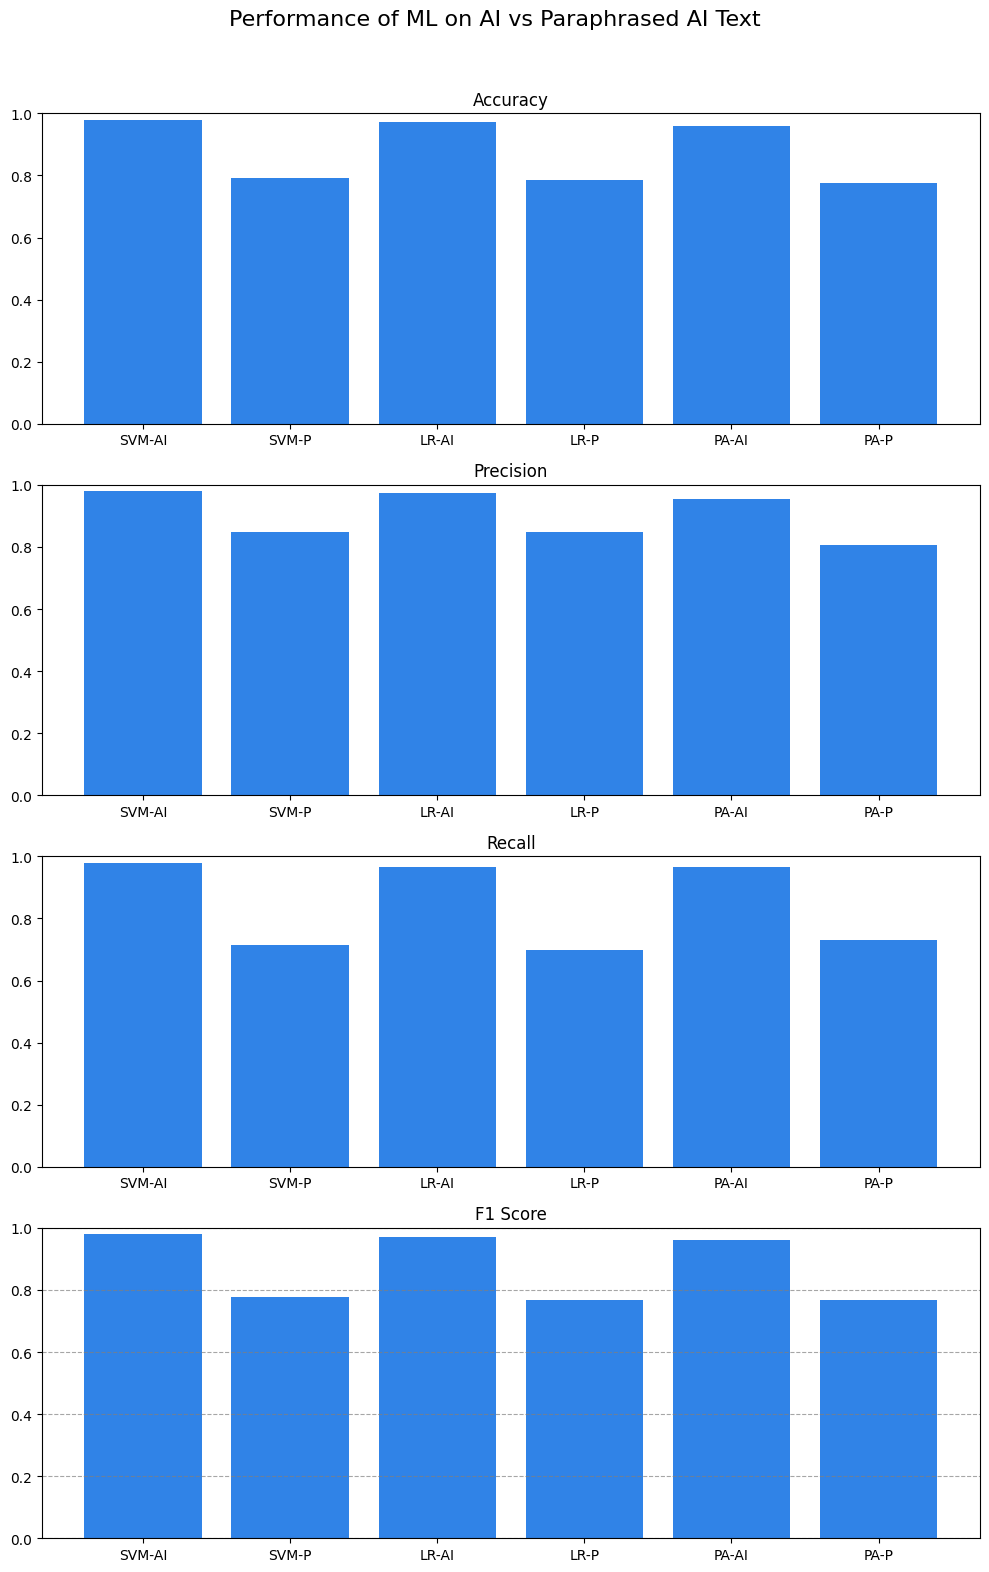

In [33]:
# Creating a bar chart comparing model performance for ML models
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

# Initialize a dictionary to hold the comparison data
comparison_data = {model_name: {metric: [] for metric in metrics} for model_name in models.keys()}

# Populate the comparison data dictionary
for metric in metrics:
    for model_name in models.keys():
        original_result = next(res for res in results if res['Model'] == model_name and res['Text Type'] == "Original")
        paraphrased_result = next(res for res in results if res['Model'] == model_name and res['Text Type'] == "Paraphrased")
        comparison_data[model_name][metric].append(original_result[metric])
        comparison_data[model_name][metric].append(paraphrased_result[metric])

custom_labels = {
    'SVM': ['SVM-AI', 'SVM-P'],
    'Logistic Regression': ['LR-AI', 'LR-P'],
    'Passive Aggressive': ['PA-AI', 'PA-P']
}

bar_color = '#3083E7'
fig, axes = plt.subplots(len(metrics), 1, figsize=(10, 16))
fig.suptitle('Performance of ML on AI vs Paraphrased AI Text', fontsize=16)
for i, metric in enumerate(metrics):
    ax = axes[i]
    for model_name in models.keys():
        original_label, paraphrased_label = custom_labels[model_name]
        ax.bar([original_label, paraphrased_label], comparison_data[model_name][metric],
               label=model_name, color=bar_color)
    ax.set_title(metric)
    ax.set_ylim(0, 1)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.grid(axis='y', linestyle='--', color='gray', alpha=0.7)
plt.show()


# Visualistions

## Accuracy, Precision, Recall, and F1 Score Bar Plot

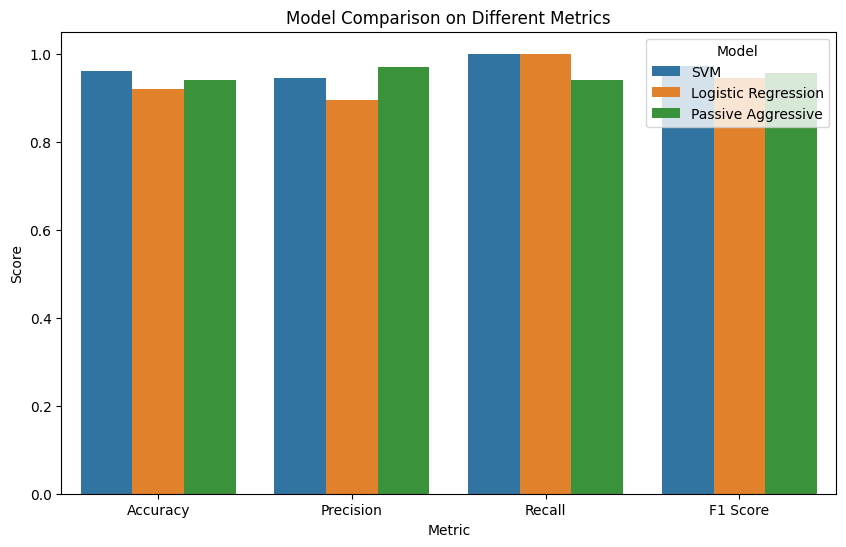

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

metrics_df = results_df.melt(id_vars='Model', var_name='Metric', value_name='Score')

plt.figure(figsize=(10, 6))
sns.barplot(x='Metric', y='Score', hue='Model', data=metrics_df)
plt.title('Model Comparison on Different Metrics')
plt.show()
